In [2]:
!pip install torchsummary
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as iio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Defining Transformation and Batch Size

In [6]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32],antialias=True)])
batch_size = 32

In [7]:
class MyDataset(Dataset):
    def __init__(self, image_path, transform = trans):
        self.image_path = image_path
        self.images = os.listdir(image_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        im = iio.imread(f"{self.image_path}/{self.images[idx]}")
        im = np.array(im)
        im = self.transform(im)
        return im

In [8]:
dataset = MyDataset("/kaggle/input/simpsons-faces/cropped")

train_loader = DataLoader(dataset, batch_size = batch_size)

In [9]:
dataset[0].shape
batch = next(iter(train_loader))

In [10]:
gpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu > 0) else "cpu")

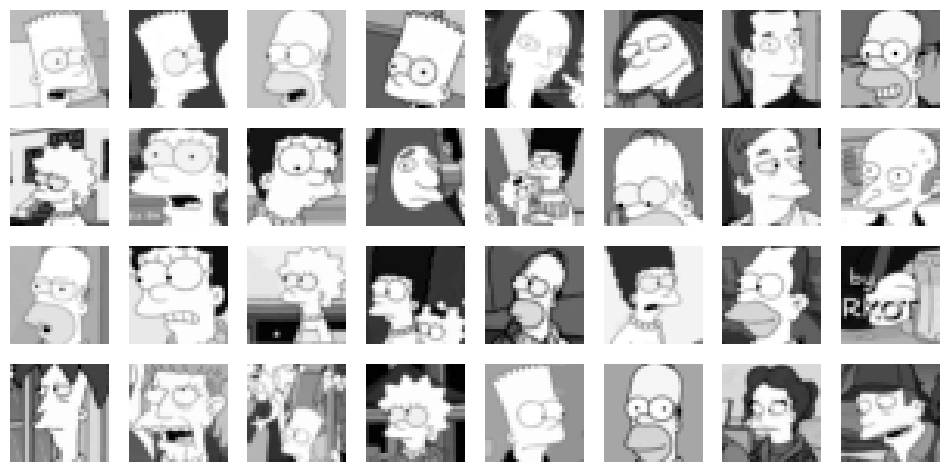

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(32):
    plt.subplot(8, 8, i+1)
    image = batch[i][0] 
    plt.axis('off')
    plt.imshow(image, cmap='gray')  # plotting the batch as greyscale images

plt.show()

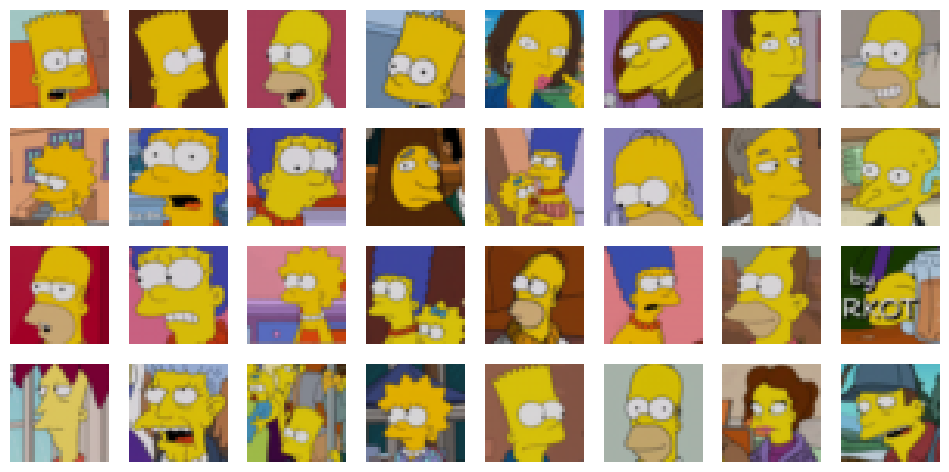

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(32):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    image = batch[i].permute(1, 2, 0)  # plotting the images as 3d
    plt.imshow(image)

plt.show()

In [13]:
import torchvision.utils as vutils
def plot_batch(batch: torch.Tensor,num : int, f_size,title:str):
    plt.figure(figsize=(f_size,f_size))
    plt.axis("off")
    plt.title(title)
    plot = plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:num], padding=0, normalize=True).cpu(), (1, 2, 0)), cmap='viridis')
    return plot

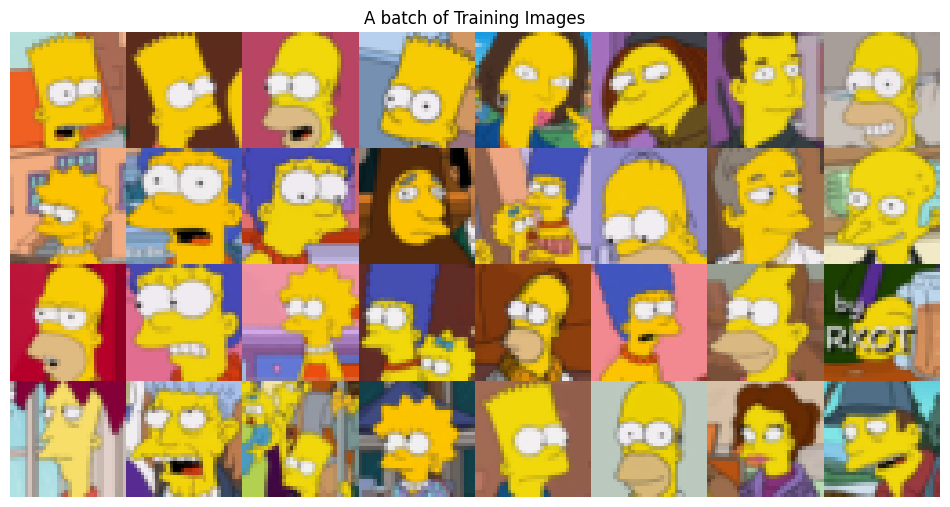

In [18]:
plot_batch(batch,32,12,title='A batch of Training Images')

Text(0.5, 1.0, 'random sample')

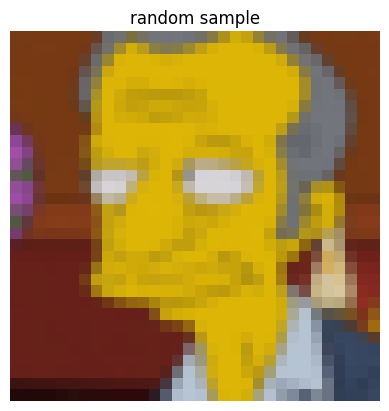

In [14]:
#plotting a sample from the dataset. 
import random
random_index = random.randint(0, len(dataset) - 1)
plt.imshow(dataset[random_index].permute(1,2,0))
plt.axis('off')
plt.title('random sample')

# VAE CLASS

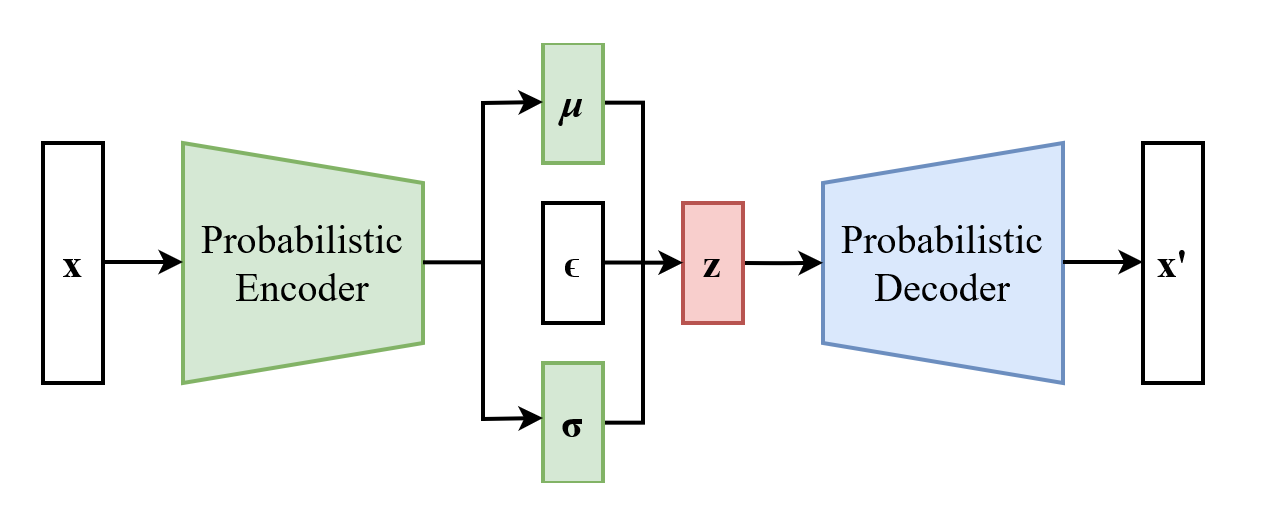

In [15]:
class VAE(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.nz = nz
        self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.ebn1 = nn.BatchNorm2d(16)
        self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.ebn2 = nn.BatchNorm2d(32)
        self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.ebn3 = nn.BatchNorm2d(64)
        self.elinear1 = nn.Linear(64*8*8, 100)
        self.ebn4 = nn.BatchNorm1d(100)
        self.elinear2 = nn.Linear(100, self.nz)
        self.dlinear1 = nn.Linear(self.nz, 100)
        self.dbn1 = nn.BatchNorm1d(100)
        self.dlinear2 = nn.Linear(100, 64*8*8)
        self.dbn2 = nn.BatchNorm1d(64*8*8)
        self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1)
        self.dbn4 = nn.BatchNorm2d(16)
        self.dtconv3 = nn.ConvTranspose2d(16, 3, 3, 1, 1)
        self.plinear1 = nn.Linear(self.nz, self.nz)
        self.plinear2 = nn.Linear(self.nz, self.nz)

    def encoder_head(self, x):
        x = torch.relu(self.econv1(x))
        x = self.ebn1(x)
        x = torch.relu(self.econv2(x))
        x = self.ebn2(x)
        x = torch.relu(self.econv3(x))
        x = self.ebn3(x)
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.elinear1(x))
        x = self.ebn4(x)
        x = torch.sigmoid(self.elinear2(x))
        return x

    def get_params(self, x):
        mu = self.plinear1(x)
        logvar = self.plinear2(x)
        return mu, logvar

    def encoder(self, x):
        x = self.encoder_head(x)
        mu, logvar = self.get_params(x)
        z = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
        return z, mu, logvar

    def decoder(self, x):
        x = torch.relu(self.dlinear1(x))
        x = self.dbn1(x)
        x = torch.relu(self.dlinear2(x))
        x = self.dbn2(x)
        x = x.view(-1, 64, 8, 8)
        x = torch.relu(self.dtconv1(x))
        x = self.dbn3(x)
        x = torch.relu(self.dtconv2(x))
        x = self.dbn4(x)
        x = torch.sigmoid(self.dtconv3(x))
        return x

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x = self.decoder(z)
        return z, x, mu, logvar

Latex KL_loss = (1/N) * sum(sum(-0.5 * (1 + log(sigma_j) - exp(log(sigma_j)) - mu_j^2)))

In [17]:
def get_loss(x, xhat, mu, logvar):
    m = 1e-4
    recon_loss = F.mse_loss(x,xhat)
    kld_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar)- mu**2), dim=1), dim=0)
    loss = m*kld_loss + (1-m)*recon_loss
    return loss

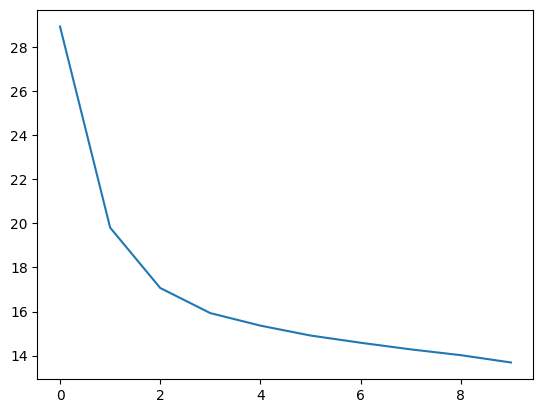

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = batch[0].to(device)

net = VAE(10).to(device)

num_epochs = 10

lr = 1e-4

opt = optim.Adam(net.parameters(), lr=lr)

ls = []

for i in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        X = batch.to(device)
        Z, Xhat, mu, logvar = net(X)
        loss = get_loss(Xhat, X, mu, logvar)
        total_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

    ls.append(total_loss)

plt.plot(ls)

In [19]:
num_samples = 64

z = torch.randn((num_samples, 10)).to(device)

with torch.no_grad():
    Xhat = net.decoder(z)

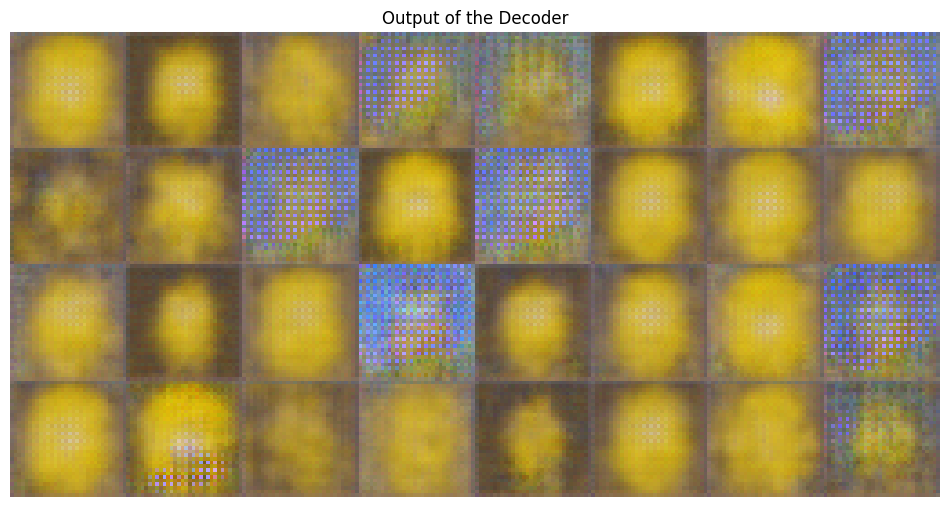

In [26]:
plot_batch(Xhat,32,12,title='Output of the Decoder')